<h1>Aim of this Notebook</h1>
The aim of this notebook is to explore and apply various techniques in machine learning (ML) and natural language processing (NLP) to develop a model capable of identifying topics associated with textual descriptions. This practice is intended to enhance my skills in both ML and NLP by tackling a multi-label classification problem. By experimenting with different models and, preprocessing method, I aim to understand the challenges and strategies involved in accurately predicting multiple categories from textual data. Through this exercise, I strive to gain a deeper insight into the intricacies of topic modeling and multi-label classification

The dataset is from https://www.kaggle.com/datasets/infamouscoder/dataset-netflix-shows .

# Imports and exploring the dataset

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy
nlp = spacy.load('en_core_web_sm')
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.model_selection import train_test_split

In [3]:
shows = pd.read_csv('netflix_titles.csv')

In [4]:
shows

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [5]:
shows.shape

(8807, 12)

In [6]:
shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


 the listed_in and description columns contains 0 nulls

# some Ex data visualizations to understand the dataset

In [7]:
shows.type.value_counts()

type
Movie      6131
TV Show    2676
Name: count, dtype: int64

In [8]:
type_counts = shows.type.value_counts()
labels = type_counts.index
sizes = type_counts.values

Text(0.5, 1.0, 'Distribution of Show Types')

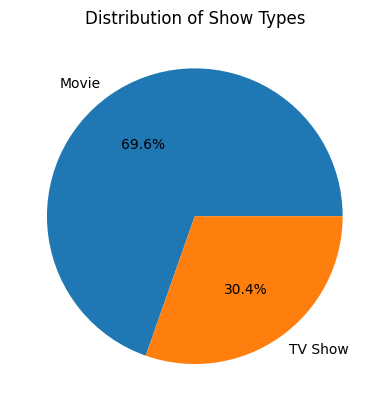

In [9]:
plt.pie(sizes, labels=labels, autopct= "%1.1f%%")
plt.title('Distribution of Show Types')

In [10]:
shows["country"].value_counts()

country
United States                             2818
India                                      972
United Kingdom                             419
Japan                                      245
South Korea                                199
                                          ... 
Romania, Bulgaria, Hungary                   1
Uruguay, Guatemala                           1
France, Senegal, Belgium                     1
Mexico, United States, Spain, Colombia       1
United Arab Emirates, Jordan                 1
Name: count, Length: 748, dtype: int64

Text(0.5, 1.0, 'Top 20 countries producing content on Netflix')

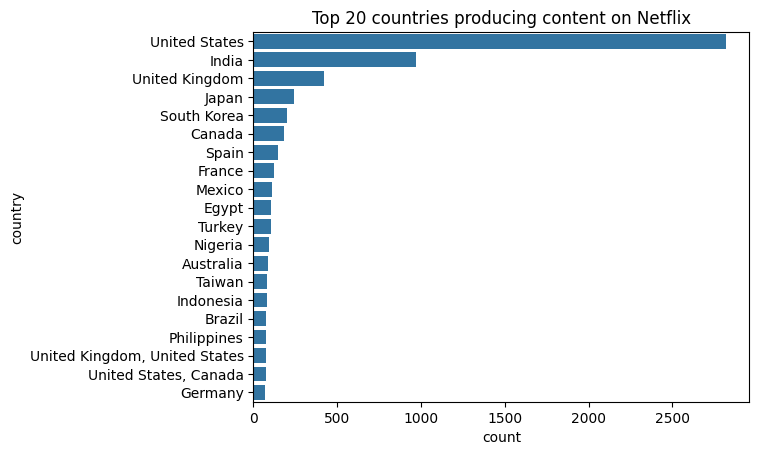

In [11]:
sns.countplot(y = 'country', order = shows['country'].value_counts().index[0:20],data = shows)
plt.title("Top 20 countries producing content on Netflix")

# preparing the data

In [12]:
# split the data to the two cloumns of interest
data = shows[['description','listed_in']]

In [13]:
data

,description,listed_in
0,"As her father nears the end of his life, filmm...",Documentaries
1,"After crossing paths at a party, a Cape Town t...","International TV Shows, TV Dramas, TV Mysteries"
2,To protect his family from a powerful drug lor...,"Crime TV Shows, International TV Shows, TV Act..."
3,"Feuds, flirtations and toilet talk go down amo...","Docuseries, Reality TV"
4,In a city of coaching centers known to train I...,"International TV Shows, Romantic TV Shows, TV ..."
...,...,...
8802,"A political cartoonist, a crime reporter and a...","Cult Movies, Dramas, Thrillers"
8803,"While living alone in a spooky town, a young g...","Kids' TV, Korean TV Shows, TV Comedies"
8804,Looking to survive in a world taken over by zo...,"Comedies, Horror Movies"
8805,"Dragged from civilian life, a former superhero...","Children & Family Movies, Comedies"


In [14]:
#getting a list with all Categories  
all_categories=",".join([cat for cat in data['listed_in']])
unique_categories_without_normalization=set(all_categories.split(","))
print("Number of Unique Categories ",len(unique_categories_without_normalization),
      unique_categories_without_normalization)

Number of Unique Categories  73 {'Stand-Up Comedy & Talk Shows', ' TV Horror', 'TV Action & Adventure', 'LGBTQ Movies', ' TV Dramas', 'Spanish-Language TV Shows', 'Reality TV', ' Stand-Up Comedy', 'Independent Movies', 'TV Horror', 'Romantic TV Shows', ' Sci-Fi & Fantasy', ' TV Comedies', 'Anime Features', ' Cult Movies', ' Science & Nature TV', ' Stand-Up Comedy & Talk Shows', ' Spanish-Language TV Shows', ' International TV Shows', 'Movies', 'International Movies', ' Dramas', 'Horror Movies', 'British TV Shows', ' Romantic Movies', 'Romantic Movies', ' Sports Movies', ' Independent Movies', ' Anime Features', 'Sci-Fi & Fantasy', ' Comedies', 'Action & Adventure', 'Anime Series', ' TV Sci-Fi & Fantasy', ' Thrillers', 'Cult Movies', 'Stand-Up Comedy', 'TV Comedies', 'Thrillers', 'Crime TV Shows', 'Children & Family Movies', 'International TV Shows', ' Reality TV', ' Korean TV Shows', 'Comedies', ' Classic Movies', 'Documentaries', 'Docuseries', 'Classic Movies', ' Music & Musicals', 'M

In [15]:
# fixing the problem of having spaces and some capitalization inconsistencies
all_categories = ",".join([cat for cat in data['listed_in']])
normalized_categories = [cat.strip().lower() for cat in all_categories.split(",")]
unique_categories = set(normalized_categories)
print("Number of Unique Categories:", len(unique_categories),unique_categories)

Number of Unique Categories: 42 {'anime features', 'action & adventure', 'international tv shows', 'tv shows', 'independent movies', 'tv thrillers', 'anime series', 'romantic tv shows', 'classic & cult tv', 'tv action & adventure', 'romantic movies', 'docuseries', 'children & family movies', 'spanish-language tv shows', 'cult movies', 'sci-fi & fantasy', 'faith & spirituality', 'tv sci-fi & fantasy', 'lgbtq movies', 'korean tv shows', 'horror movies', 'crime tv shows', 'reality tv', 'music & musicals', 'science & nature tv', 'tv comedies', 'stand-up comedy & talk shows', 'documentaries', 'tv horror', 'stand-up comedy', 'comedies', 'tv mysteries', "kids' tv", 'international movies', 'movies', 'dramas', 'british tv shows', 'thrillers', 'sports movies', 'classic movies', 'tv dramas', 'teen tv shows'}


In [16]:
#Normalization for our data also

data['listed_in'] = data['listed_in'].apply(lambda x: [cat.strip().lower() for cat in x.split(",")])


C:\Users\DELL\AppData\Local\Temp\ipykernel_17160\2219782267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['listed_in'] = data['listed_in'].apply(lambda x: [cat.strip().lower() for cat in x.split(",")])


In [17]:
data.head()

,description,listed_in
0,"As her father nears the end of his life, filmm...",[documentaries]
1,"After crossing paths at a party, a Cape Town t...","[international tv shows, tv dramas, tv mysteries]"
2,To protect his family from a powerful drug lor...,"[crime tv shows, international tv shows, tv ac..."
3,"Feuds, flirtations and toilet talk go down amo...","[docuseries, reality tv]"
4,In a city of coaching centers known to train I...,"[international tv shows, romantic tv shows, tv..."


In [18]:
pd.set_option('display.max_columns', 45) # expanding the max to see all data later

In [19]:
#creating a function to identify and label the cells
def isCategory(categories, category):
    if category in categories:
        return 1
    else:
        return 0

# Create indicator columns for each unique category
for cat in unique_categories:
    data[cat] = data['listed_in'].apply(lambda x: isCategory(x, cat))


C:\Users\DELL\AppData\Local\Temp\ipykernel_17160\101113493.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cat] = data['listed_in'].apply(lambda x: isCategory(x, cat))
C:\Users\DELL\AppData\Local\Temp\ipykernel_17160\101113493.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[cat] = data['listed_in'].apply(lambda x: isCategory(x, cat))
C:\Users\DELL\AppData\Local\Temp\ipykernel_17160\101113493.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [20]:
data.head(20)

,description,listed_in,anime features,action & adventure,international tv shows,tv shows,independent movies,tv thrillers,anime series,romantic tv shows,classic & cult tv,tv action & adventure,romantic movies,docuseries,children & family movies,spanish-language tv shows,cult movies,sci-fi & fantasy,faith & spirituality,tv sci-fi & fantasy,lgbtq movies,korean tv shows,horror movies,crime tv shows,reality tv,music & musicals,science & nature tv,tv comedies,stand-up comedy & talk shows,documentaries,tv horror,stand-up comedy,comedies,tv mysteries,kids' tv,international movies,movies,dramas,british tv shows,thrillers,sports movies,classic movies,tv dramas,teen tv shows
0,"As her father nears the end of his life, filmm...",[documentaries],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"After crossing paths at a party, a Cape Town t...","[international tv shows, tv dramas, tv mysteries]",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,To protect his family from a powerful drug lor...,"[crime tv shows, international tv shows, tv ac...",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Feuds, flirtations and toilet talk go down amo...","[docuseries, reality tv]",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,In a city of coaching centers known to train I...,"[international tv shows, romantic tv shows, tv...",0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,The arrival of a charismatic young priest brin...,"[tv dramas, tv horror, tv mysteries]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
6,Equestria's divided. But a bright-eyed hero be...,[children & family movies],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,"On a photo shoot in Ghana, an American model s...","[dramas, independent movies, international mov...",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
8,A talented batch of amateur bakers face off in...,"[british tv shows, reality tv]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,A woman adjusting to life after a loss contend...,"[comedies, dramas]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [21]:
data = data.drop('listed_in', axis=1)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   description                   8807 non-null   object
 1   anime features                8807 non-null   int64 
 2   action & adventure            8807 non-null   int64 
 3   international tv shows        8807 non-null   int64 
 4   tv shows                      8807 non-null   int64 
 5   independent movies            8807 non-null   int64 
 6   tv thrillers                  8807 non-null   int64 
 7   anime series                  8807 non-null   int64 
 8   romantic tv shows             8807 non-null   int64 
 9   classic & cult tv             8807 non-null   int64 
 10  tv action & adventure         8807 non-null   int64 
 11  romantic movies               8807 non-null   int64 
 12  docuseries                    8807 non-null   int64 
 13  children & family 

In [27]:
punctuations = string.punctuation
stopwords = list(STOP_WORDS)
# function to make the preprocessing on the description column
def process_description(text):
    doc = nlp(text)
    # Remove punctuation, stopwords, and apply lemmatization
    processed_text = " ".join([token.lemma_.lower().strip() for token in doc
                               if token.text not in punctuations and token.text.lower() not in stopwords])
    return processed_text

In [28]:
data['description'] = data['description'].apply(process_description)

In [29]:
data.head()

,description,anime features,action & adventure,international tv shows,tv shows,independent movies,tv thrillers,anime series,romantic tv shows,classic & cult tv,tv action & adventure,romantic movies,docuseries,children & family movies,spanish-language tv shows,cult movies,sci-fi & fantasy,faith & spirituality,tv sci-fi & fantasy,lgbtq movies,korean tv shows,horror movies,crime tv shows,reality tv,music & musicals,science & nature tv,tv comedies,stand-up comedy & talk shows,documentaries,tv horror,stand-up comedy,comedies,tv mysteries,kids' tv,international movies,movies,dramas,british tv shows,thrillers,sports movies,classic movies,tv dramas,teen tv shows
0,father near end life filmmaker kirsten johnson...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,cross path party cape town teen set prove priv...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,protect family powerful drug lord skilled thie...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,feuds flirtation toilet talk incarcerated woma...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,city coach center know train india fine colleg...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# train test split for our model
x = data['description']
y = data.drop(columns=['description'])
X_train, X_val, y_train, y_val = train_test_split(x,y,train_size=0.75,random_state=21)

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
# using the TfidfVectorizer to transform our x because the model doesn't work on text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_val)
print(X_train_tfidf)

  (0, 11704)	0.3190784988781268
  (0, 11459)	0.3482246030695923
  (0, 11144)	0.2486759172797333
  (0, 3228)	0.31645904210094206
  (0, 13043)	0.21222714810576263
  (0, 4563)	0.1609296400422493
  (0, 7041)	0.14155684590900533
  (0, 4072)	0.27986501760003957
  (0, 7199)	0.16987019519506977
  (0, 8263)	0.1616187961459739
  (0, 9285)	0.32185680509435577
  (0, 7998)	0.21691035631108302
  (0, 10974)	0.25691547905192474
  (0, 3639)	0.41715348800030666
  (1, 12221)	0.2584092204489616
  (1, 5426)	0.22549164665489116
  (1, 7178)	0.1888795129997877
  (1, 9142)	0.2517619749851
  (1, 3147)	0.33187039091580367
  (1, 1223)	0.17421722203182644
  (1, 4236)	0.3170875745115312
  (1, 8804)	0.33187039091580367
  (1, 5864)	0.23313782888788226
  (1, 3272)	0.2091024509916529
  (1, 13170)	0.27703336654617927
  :	:
  (6603, 9386)	0.3236034831210951
  (6603, 3701)	0.2082705933575804
  (6603, 8395)	0.24690225639035945
  (6603, 11943)	0.22789984472517721
  (6603, 9773)	0.21690546918055564
  (6603, 4201)	0.206372106

# Building the Model

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define a Gradient Boosting classifier as our model
classifier =GradientBoostingClassifier(random_state=21)

# Create a pipeline with the classifier
pipeline = Pipeline([
    ('clf', MultiOutputClassifier(classifier))
])

# Train the pipeline
pipeline.fit(X_train_tfidf, y_train)

#making predictions on new data 
predictions = pipeline.predict(X_test_tfidf)


In [37]:
predictions

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
from sklearn.metrics import accuracy_score
# measuring our model accuracy
accuracy = accuracy_score(y_val, predictions)

print("Accuracy:", accuracy*100)


Accuracy: 6.130790190735695


<h2>My hypothesis on Model Performance:</h2>

The initially low accuracy otheur multi-label classification model can be attributed to the complexity of the problem, specifically the large number of target columns (42 categories). Multi-label classification tasks with a high number of labels pose significant challenges, as the model must learn to make accurate predictions across many dimensions simultaneously. This complexity often leads to difficulties in capturing the necessary patterns and relationships within the data, resulting in suboptimal model performance.

In [40]:
#printing an example to see how the model predict and compare to the actual
print(predictions[3])
print(y_val.iloc[3])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0]
anime features                  0
action & adventure              0
international tv shows          0
tv shows                        0
independent movies              0
tv thrillers                    0
anime series                    0
romantic tv shows               0
classic & cult tv               0
tv action & adventure           0
romantic movies                 0
docuseries                      0
children & family movies        0
spanish-language tv shows       0
cult movies                     0
sci-fi & fantasy                0
faith & spirituality            0
tv sci-fi & fantasy             0
lgbtq movies                    0
korean tv shows                 0
horror movies                   0
crime tv shows                  0
reality tv                      0
music & musicals                0
science & nature tv             0
tv comedies                     0
stand-up comedy & talk shows 

In [42]:
#viewing the percentage of all categories
TARGET_COLS = ["kids' tv", 'tv comedies', 'docuseries', 'tv shows', 'action & adventure', 'classic & cult tv',
               'thrillers', 'reality tv', 'stand-up comedy & talk shows', 'lgbtq movies', 'anime series',
               'comedies', 'faith & spirituality', 'tv dramas', 'tv action & adventure', 'international tv shows',
               'tv horror', 'sci-fi & fantasy', 'independent movies', 'music & musicals', 'documentaries',
               'cult movies', 'teen tv shows', 'stand-up comedy', 'romantic movies', 'tv mysteries',
               'british tv shows', 'dramas', 'tv thrillers', 'classic movies', 'sports movies', 'korean tv shows',
               'spanish-language tv shows', 'romantic tv shows', 'movies', 'tv sci-fi & fantasy', 'anime features',
               'science & nature tv', 'crime tv shows', 'horror movies', 'international movies',
               'children & family movies']
print('The percentage of each category is:')
100 * (data[TARGET_COLS].sum()/(data.shape[0])).sort_values(ascending=False)

The percentage of each category is:


international movies            31.247871
dramas                          27.557625
comedies                        19.007608
international tv shows          15.340070
documentaries                    9.867151
action & adventure               9.753605
tv dramas                        8.663563
independent movies               8.584081
children & family movies         7.278301
romantic movies                  6.994436
tv comedies                      6.597025
thrillers                        6.551607
crime tv shows                   5.336664
kids' tv                         5.120927
docuseries                       4.485069
music & musicals                 4.257977
romantic tv shows                4.201204
horror movies                    4.053594
stand-up comedy                  3.894629
reality tv                       2.895424
british tv shows                 2.872715
sci-fi & fantasy                 2.759169
sports movies                    2.486658
anime series                     1

In [43]:
top_10_col = ["International Movies","Dramas","Comedies","International TV Shows","Documentaries",
              "Action & Adventure","TV Dramas","Independent Movies","Children & Family Movies","Romantic Movies"]


In [44]:
#filtering the data to contain only the most common 10 categories
filtered_df = data.drop(columns=["kids' tv", 'tv comedies', 'docuseries', 'tv shows', 'classic & cult tv',
'thrillers', 'reality tv', 'stand-up comedy & talk shows', 'lgbtq movies', 'anime series',
'faith & spirituality', 'tv action & adventure', 'tv horror', 'sci-fi & fantasy', 
'music & musicals', 'cult movies', 'teen tv shows', 'stand-up comedy', 'tv mysteries',
'british tv shows', 'tv thrillers', 'classic movies', 'sports movies', 'korean tv shows',
'spanish-language tv shows', 'romantic tv shows', 'movies', 'tv sci-fi & fantasy', 'anime features',
'science & nature tv', 'crime tv shows', 'horror movies'])

filtered_df

,description,action & adventure,international tv shows,independent movies,romantic movies,children & family movies,documentaries,comedies,international movies,dramas,tv dramas
0,father near end life filmmaker kirsten johnson...,0,0,0,0,0,1,0,0,0,0
1,cross path party cape town teen set prove priv...,0,1,0,0,0,0,0,0,0,1
2,protect family powerful drug lord skilled thie...,0,1,0,0,0,0,0,0,0,0
3,feuds flirtation toilet talk incarcerated woma...,0,0,0,0,0,0,0,0,0,0
4,city coach center know train india fine colleg...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
8802,political cartoonist crime reporter pair cop i...,0,0,0,0,0,0,0,0,1,0
8803,live spooky town young girl befriend motley cr...,0,0,0,0,0,0,0,0,0,0
8804,look survive world take zombie dorky college s...,0,0,0,0,0,0,1,0,0,0
8805,drag civilian life superhero train new crop yo...,0,0,0,0,1,0,1,0,0,0


In [46]:
#making new train test split with the data
x = filtered_df['description']
y = filtered_df.drop(columns=['description'])
X_train, X_val, y_train, y_val = train_test_split(x,y,train_size=0.75,random_state=21)

In [48]:
# factorizing the data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_val)


In [49]:
# train the model on the new data and making the predections
pipeline.fit(X_train_tfidf, y_train)

predictions = pipeline.predict(X_test_tfidf)


In [50]:
print(predictions)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [51]:
accuracy = accuracy_score(y_val, predictions)

print("Accuracy:", accuracy*100)


Accuracy: 23.29700272479564


In [52]:
print(predictions[3])
print(y_val.iloc[3])

[0 0 0 0 0 0 0 1 1 0]
action & adventure          0
international tv shows      0
independent movies          0
romantic movies             0
children & family movies    0
documentaries               0
comedies                    0
international movies        1
dramas                      1
tv dramas                   0
Name: 3790, dtype: int64


<h2>Verification and Conclusion:</h2>

To verify this hypothesis, I reduced the number of target columns to the top 10 most frequent categories and retrained the model. This reduction in complexity led to a significant increase in accuracy, confirming that the model performs better with fewer target variables. This result suggests that the original problem was too complex for our current model setup. Future work may involve exploring more advanced models or techniques designed for handling high-dimensional multi-label classification tasks, as well as further tuning and feature engineering to improve performance across all categories.